Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Logistic Regression and SVMs of AirBnB Data

### Instructions
[50 Points]
* Assess performance of each model using 80/20 training-test split
* Adjust model parameters to optimize accuracy
    * if dataset size requires stochastic gradient descent, then only linear kernel is appropriate
    
[10 Points]
* Discuss advantages of each model for each classification task
* Does one type of model offer superior performance over another in terms of prediction accuracy?
    * In terms of training time or efficiency? Explain.

[30 points]
* Use weights from logistic regression to interpret importance of different features for each classification task. Explain interpretation in detail.
    * Why do you think some variables are more important?
    
[10 points]
* Look at the chosen support vectors for the classifcation task. Do these provide any insight into the data? Explain.

## Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the inherent richness of the variables also allows

Airbnb Superhosts are experienced property owners who guests have helped rate as the best of the best. Earning this designation requires obtaining a minimum number of yearly stays, maintaining a high response rate, keeping above a certain score average, and avoiding cancellations. However, is it possible to predict Superhost status off of other attributes on the listing? For simplicity we define a Superhost as someone with a score average greater than or equal to 96%.

**Setup**

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
#import plotly.graph_objects as go
import datetime
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings

In [81]:
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df.dtypes

id                           int64
log_price                  float64
property_type               object
room_type                   object
amenities                   object
accommodates                 int64
bathrooms                  float64
bed_type                    object
cancellation_policy         object
cleaning_fee                  bool
city                        object
description                 object
first_review                object
host_has_profile_pic        object
host_identity_verified      object
host_response_rate          object
host_since                  object
instant_bookable            object
last_review                 object
latitude                   float64
longitude                  float64
name                        object
neighbourhood               object
number_of_reviews            int64
review_scores_rating       float64
thumbnail_url               object
zipcode                     object
bedrooms                   float64
beds                

The first step to preparing the Airbnb dataset for use with logistic regression and support vector machines is to remove or impute missing data and change the variables to compatible datatypes. Much of the logic behind this work was covered in Lab 1.

**Cleanup (from first project)**

In [82]:
##Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [83]:
##Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
df_imputed[ints] = df_imputed[ints].astype(np.int64)

Additionally, some of the existing attributes can be transformed into a potentially more useful datatype.

In [84]:
df_imputed['price'] = np.exp(df_imputed['log_price'])

In [85]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

In [86]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Columns that are not meaningful in a modeling context (e.g., index, id), redundant with newly engineered features (e.g., amenities, description), or likely not useful in predicting the target variable superuser (e.g., zipcode, thumbnail_url) are removed. 

In [96]:
# delete useless columns
df_logistic = df_imputed.drop(['index', 'id', 'log_price', 'amenities', 'description', 'zipcode', 'description',
                      'latitude', 'longitude', 'name', 'neighbourhood', 'review_scores_rating',
                      'thumbnail_url', 'zipcode'], axis=1)

# Delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

In [97]:
categorical_vars = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
df_logistic[categorical_vars].apply(lambda x: len(x.value_counts()), axis=0)

property_type          32
room_type               3
bed_type                5
cancellation_policy     5
city                    6
dtype: int64

In [98]:
# Remove factor with unnecessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

In [99]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 25 columns):
room_type                 57389 non-null category
accommodates              57389 non-null int64
bathrooms                 57389 non-null float64
bed_type                  57389 non-null category
cancellation_policy       57389 non-null category
cleaning_fee              57389 non-null bool
city                      57389 non-null category
host_has_profile_pic      57389 non-null bool
host_identity_verified    57389 non-null bool
host_response_rate        57388 non-null float64
instant_bookable          57389 non-null bool
number_of_reviews         57389 non-null int64
bedrooms                  57389 non-null int64
beds                      57389 non-null int64
price                     57389 non-null float64
length_amenities          57389 non-null int64
internet                  57389 non-null bool
TV                        57389 non-null bool
air_conditioning          57389 n

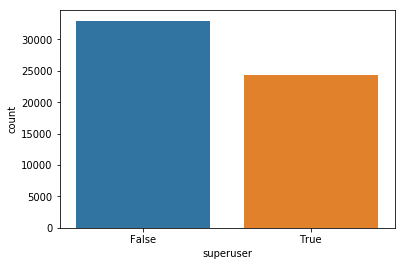

In [91]:
sns.countplot(data=df_logistic, x='superuser')

A simple bar chart of the counts shows that both classes of Superuser are well-represented in the remaining data.

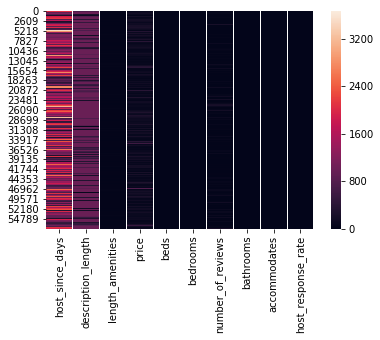

In [92]:
numerical_features = ['host_since_days', 'description_length', 'length_amenities', 'price', 'beds',
                     'bedrooms', 'number_of_reviews', 'bathrooms', 'accommodates', 'host_response_rate']
sns.heatmap(df_logistic[numerical_features])

Collinearity does not appear to be a concern based on the numeric variables. However, it is worth noting that there are vast scaling differences. For example, host_since_days counts the number of days a listing existed until a given date, resulting in a mean in the thousands because many listings have been active for several years. In contrast, host_response_rate is a percentage. Standardizing these values to account for this may be useful, and is explored later on.

## Create Models

### Logistic Regression Model

In [15]:
##Basic model, all numeric data
#x_train, x_test, y_train, y_test = train_test_split(df_imputed.loc[:,['log_price','accommodates','bathrooms','number_of_reviews','review_scores_rating','bedrooms','beds']]
#                                                    , df_imputed.loc[:,['grade']], test_size=0.2, random_state=0)
#LogisticRegression().fit(x_train,y_train).predict(x_test[0].reshape(1,-1))

### Interpretation of Feature Importance

<i>[30 points]
* Use weights from logistic regression to interpret importance of different features for each classification task. Explain interpretation in detail.
    * Why do you think some variables are more important?</i>

### Support Vector Machine Model

### Interpretation of Support Vectors

<i>[10 pts] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.</i>

## Model Comparisons: Advantages, Performance, Efficiency

<i>[10 Points]
* Discuss advantages of each model for each classification task
* Does one type of model offer superior performance over another in terms of prediction accuracy?
    * In terms of training time or efficiency? Explain.</i>